# Mobile 고객 이탈 분석

* 여러분은 OO 통신화사 데이터분석가 입니다.
* 회사는 약정기간이 끝난 고객이 번호이동(이탈)해 가는 문제를 해결하고자 합니다.
* 그래서 여러분에게, 어떤 고객이 번호이동(이탈)해 가는지 데이터분석을 의뢰하였습니다.
* 고객 이탈여부(CHURN)에 영향을 주는 요인을 찾아 봅시다.

![](https://d18lkz4dllo6v2.cloudfront.net/cumulus_uploads/entry/23964/mobile%20phones.png)

## 0.환경설정

### 1) 라이브러리 로딩

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.mosaicplot import mosaic
from scipy import stats as spst
import statsmodels.api as sm

### 2) 데이터 로딩

In [4]:
# mobile data
data_path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_NA2.csv"
mobile = pd.read_csv(data_path)
mobile.drop(['id', 'REPORTED_USAGE_LEVEL','OVER_15MINS_CALLS_PER_MONTH'], axis = 1, inplace = True)
mobile.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,1,47711,183,17,730589.0,192,5,unsat,considering,0
1,0,74132,191,43,535092.0,349,2,unsat,no,1
2,1,150419,0,14,204004.0,682,6,unsat,considering,0
3,0,159567,0,58,281969.0,634,1,very_unsat,never_thought,0
4,1,23392,0,0,216707.0,233,15,unsat,no,1


|변수 명|내용|구분|
|	----	|	----	|	----	|
|	COLLEGE	|	대학졸업 여부(1,0)	|		|
|	INCOME	|	연 수입액(달러)	|		|
|	OVERAGE	|	월 초과사용 시간(분)	|		|
|	LEFTOVER	|	월 사용 잔여시간(%)	|		|
|	HOUSE	|	집 가격(달러)	|		|
|	HANDSET_PRICE	|	핸드폰 가격(달러)	|		|
|	AVERAGE_CALL_DURATION	|	평균 통화시간(분)	|		|
|	REPORTED_SATISFACTION	|	만족도 설문('very_unsat', 'unsat', 'avg', 'sat', 'very_sat' )	|		|
|	CONSIDERING_CHANGE_OF_PLAN	|	변경 계획 설문('never_thought', 'no', 'perhaps', 'considering',   'actively_looking_into_it')	|		|
|	**CHURN**	|	이탈여부(1 : 이탈, 0 : 잔류)	|	Label	|


In [4]:
mobile.isna().sum()

COLLEGE                         0
INCOME                          0
OVERAGE                         0
LEFTOVER                        0
HOUSE                         215
HANDSET_PRICE                   0
AVERAGE_CALL_DURATION           0
REPORTED_SATISFACTION          38
CONSIDERING_CHANGE_OF_PLAN      0
CHURN                           0
dtype: int64

----

## 1.가설수립

* 숫자형 최소 3개이상, 범주형 최소 2개 이상씩, 전체 6개의 변수를 도출, 가설을 수립하시오.

* 가설1 : 변경계획설문중 고려중인 사람이 많을 수록 이탈율이 높을 것이다.

* 가설2 : 만족도 설문에서 만족하지 않을 수록 이탈율이 높을 것이다

* 가설3 : 월 사용 잔여 시간이 높을수록 이탈율이 높을 것이다

* 가설4 : 월 초과 사용 시간이 높을 수록 이탈율이 높을 것이다.

* 가설5 : 대학 졸업 여부에 따라 이탈율과 관련이 있을 것이다.

* 가설6 : 연 수입액이 높을 수록 이탈율이 증가할 것이다

----

## 2.단변량 분석

① 변수의 비즈니스 의미  

② 숫자? 범주?  

③ 전처리 사항
   - NaN 존재 여부 및 조치 방안  
   - 가변수화 대상여부  
   
④ 기초통계량

⑤ 분포  

⑥ 위 정보로부터 파악한 내용(비즈니스!) 정리  

⑦ 추가 분석해볼 사항 도출

### 1) REPORTED_SATISFACTION (만족도 설문)

범주형

In [7]:
mobilen = mobile.loc[mobile['REPORTED_SATISFACTION'].notnull()]

In [12]:
repd = mobilen['REPORTED_SATISFACTION'].value_counts()
print(repd)

very_unsat    7072
very_sat      4562
unsat         3590
avg           1806
sat            932
Name: REPORTED_SATISFACTION, dtype: int64


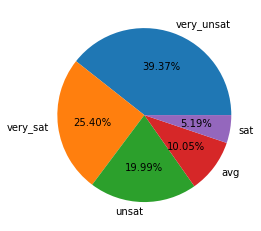

In [13]:
plt.pie(repd.values, labels = repd.index, autopct = '%.2f%%')
plt.show()

불만족하는 고객의 비율이 59.36%로 절반이 넘는다.
  불만족의 이유를 파악해야함.

### 2) HANDSET_PRICE (핸드폰 가격)

숫자형

In [16]:
hand = mobile['HANDSET_PRICE'].describe()
print(hand)

count    18000.000000
mean       390.096667
std        214.239639
min        130.000000
25%        219.000000
50%        326.000000
75%        536.000000
max        899.000000
Name: HANDSET_PRICE, dtype: float64


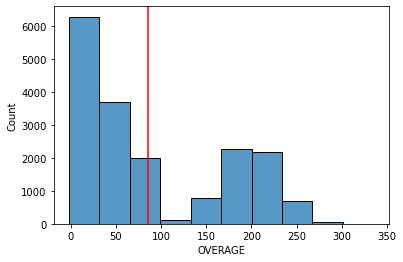

In [7]:
sns.histplot(mobile['OVERAGE'], bins = 10)
plt.axvline(mobile['OVERAGE'].mean() , color = 'r')
plt.show()

핸드폰의 가격은 400달려 미만이 많다.

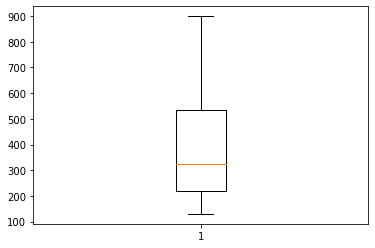

In [5]:
plt.boxplot(mobile['HANDSET_PRICE'])
plt.show()

### 3) INCOME (연 수입액)

숫자형

count     18000.000000
mean      80314.400278
std       41703.420130
min       20007.000000
25%       42151.500000
50%       75501.500000
75%      116082.250000
max      159983.000000
Name: INCOME, dtype: float64


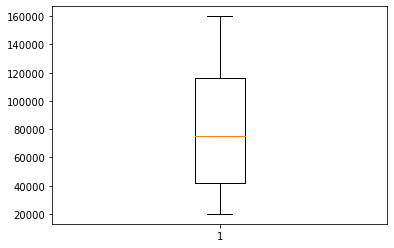

In [30]:
income = mobile['INCOME'].describe()
print(income)
plt.boxplot(mobile['INCOME'])
plt.show()

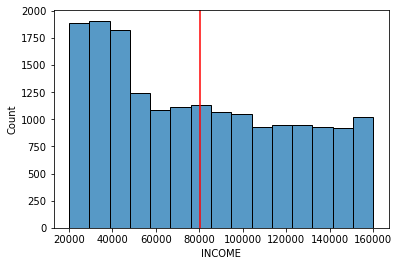

In [23]:
sns.histplot(mobile['INCOME'], bins = 15)
plt.axvline(mobile['INCOME'].mean() , color = 'r')
plt.show()

연 수입액이 20000달러에서 60000달러 사이가 많다. 20000달러와 60000달러 사이의 데이터를 떼어내서 분석 필요.

### 4) CONSIDERING_CHANGE_OF_PLAN (변경계획설문)

범주형

In [26]:
chop = mobile['CONSIDERING_CHANGE_OF_PLAN'].value_counts()
print(chop)

considering                 7141
actively_looking_into_it    4453
no                          3644
never_thought               1804
perhaps                      958
Name: CONSIDERING_CHANGE_OF_PLAN, dtype: int64


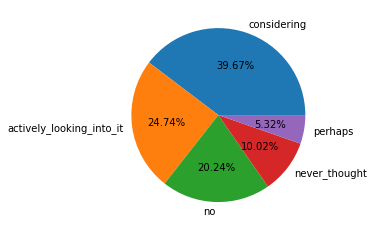

In [27]:
plt.pie(chop.values, labels = chop.index, autopct = '%.2f%%')
plt.show()

64.41퍼센트의 고객이 변경계획을 고려하거나, 변경할 것이다. 변경 계획을 가진 고객의 데이터를 분석 필요.

### 5) AVERAGE_CALL_DURATION (평균 통화시간)

숫자형

count    18000.000000
mean         5.990944
std          4.398894
min          1.000000
25%          2.000000
50%          5.000000
75%         10.000000
max         15.000000
Name: AVERAGE_CALL_DURATION, dtype: float64


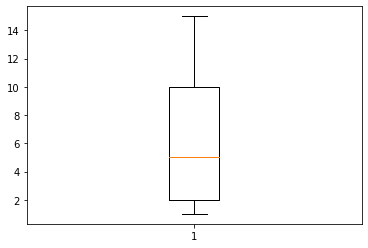

In [29]:
acd = mobile['AVERAGE_CALL_DURATION'].describe()
print(acd)
plt.boxplot(mobile['AVERAGE_CALL_DURATION'])
plt.show()

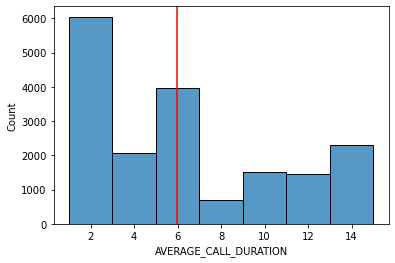

In [36]:
sns.histplot(mobile['AVERAGE_CALL_DURATION'], bins = 7)
plt.axvline(mobile['AVERAGE_CALL_DURATION'].mean() , color = 'r')
plt.show()

고객들중 많은 비율이 7분 이내의 평균 통화시간을 가진다.

### 6) LEFTOER (월 사용 잔여시간)

숫자형

count    18000.000000
mean        23.995500
std         26.860363
min          0.000000
25%          0.000000
50%         14.500000
75%         42.000000
max         89.000000
Name: LEFTOVER, dtype: float64


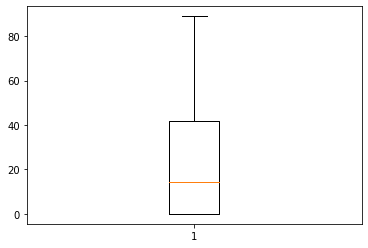

In [38]:
lt = mobile['LEFTOVER'].describe()
print(lt)
plt.boxplot(mobile['LEFTOVER'])
plt.show()

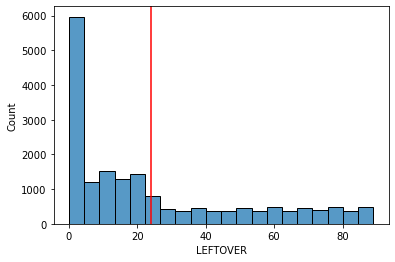

In [41]:
sns.histplot(mobile['LEFTOVER'], bins = 20)
plt.axvline(mobile['LEFTOVER'].mean() , color = 'r')
plt.show()

월 사용 잔여시간은 5퍼센트 이하가 많은 것으로 보인다.

### 7) CHURN(target)

범주형

In [42]:
churn = mobile['CHURN'].value_counts()
print(churn)

0    9131
1    8869
Name: CHURN, dtype: int64


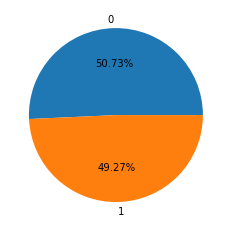

In [43]:
plt.pie(churn.values, labels = churn.index, autopct = '%.2f%%')
plt.show()

고객의 이탈이 49.27퍼센트로 높다.

### 8) COLLEGE (대학졸업 여부)

범주형

In [44]:
col = mobile['COLLEGE'].value_counts()
print(col)

1    9049
0    8951
Name: COLLEGE, dtype: int64


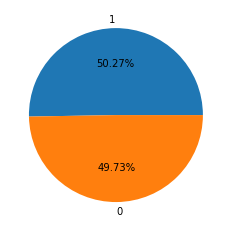

In [45]:
plt.pie(col.values, labels = col.index, autopct = '%.2f%%')
plt.show()

대학 졸업여부에 대한 이탈율 분석 필요.

## 3.이변량 분석 
* 자료의 종류에 맞게 X --> Y 에 대해서 그래프(시각화)와 가설검정(수치화)를 수행하고 결과를 평가합니다.
* 가설검정시 다음의 항목을 참조하여 수행합니다.
    * 유의수준 : 5%
    * 숫자 --> 숫자 : 상관분석
    * 범주 --> 범주 : 카이제곱검정
    * 범주 --> 숫자 : t검정, 분산분석
    * 숫자 --> 범주 : 로지스틱 회귀모형을 통해, 회귀계수의 P.value로 검정을 수행합니다.


In [ ]:
target = 'CHURN'

### (1) 범주형 COLLEGE --> CHURN
* 모든 범주형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  
    ① 교차표(pd.crosstab())  
    ② 시각화( Stacked Bar, Mosaic)  
    ③ 가설검정(카이제곱검정)
* 각 feature 별로 관계의 정도를 3가지로 정리해봅시다. 

#### 1) COLLEGE --> CHURN

In [46]:
CC = pd.crosstab(mobile['COLLEGE'], mobile['CHURN'], normalize = 'index')

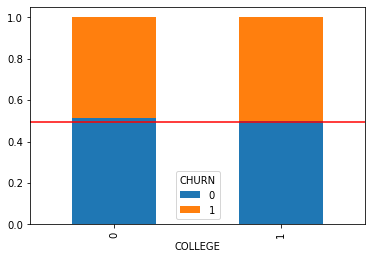

In [47]:
CC.plot.bar(stacked = True)
plt.axhline(mobile['CHURN'].mean(), color  = 'r')
plt.show()

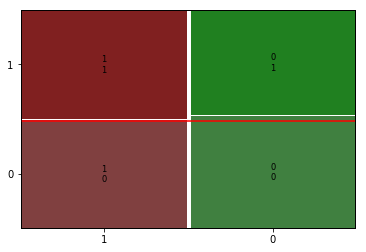

In [48]:
mosaic(mobile, ['COLLEGE', 'CHURN'], gap = 0.01)
plt.axhline(mobile['CHURN'].mean(), color  = 'r')
plt.show()

In [49]:
CCK = pd.crosstab(mobile['COLLEGE'], mobile['CHURN'])
result = spst.chi2_contingency(CCK)
print('카이검정 : ', result[0])
print('p_value : ',result[1])
print('자유도 : ', result[2])

카이검정 :  4.982102934693502
p_value :  0.02561083347822053
자유도 :  1


1.대학졸업여부와 이탈 여부는 큰 차이가 없다.

2.대학졸업 여부를 통해 청소년과 성인의 이탈여부의 차이를 알고자 했는데 큰 차이가 없는것 같다.

#### 2) REPORTED_SATISFACTION --> CHURN

In [50]:
RC = pd.crosstab(mobile['REPORTED_SATISFACTION'], mobile['CHURN'], normalize = 'index')

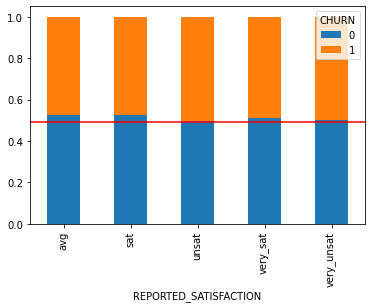

In [51]:
RC.plot.bar(stacked = True)
plt.axhline(mobile['CHURN'].mean(), color  = 'r')
plt.show()

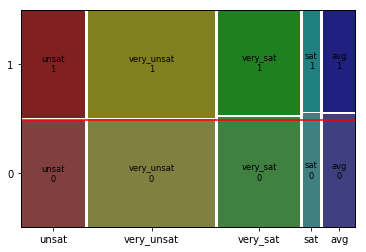

In [52]:
mosaic(mobile, ['REPORTED_SATISFACTION', 'CHURN'], gap = 0.01)
plt.axhline(mobile['CHURN'].mean(), color  = 'r')
plt.show()

In [53]:
RCK = pd.crosstab(mobile['REPORTED_SATISFACTION'], mobile['CHURN'])
result = spst.chi2_contingency(RCK)
print('카이검정 : ', result[0])
print('p_value : ',result[1])
print('자유도 : ', result[2])

카이검정 :  6.841100957205645
p_value :  0.14452738878905058
자유도 :  4


1.만족도 설문과 이탈여부는 관계가 없다.

#### 3) CONSIDERING_CHANGE_OF_PLAN --> CHURN

In [54]:
COPC = pd.crosstab(mobile['CONSIDERING_CHANGE_OF_PLAN'], mobile['CHURN'], normalize = 'index')

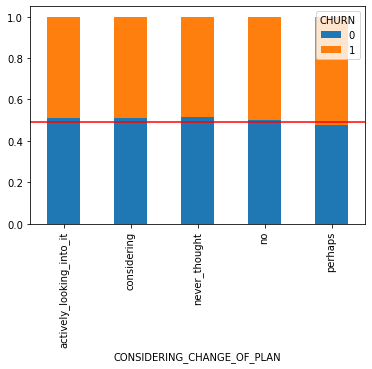

In [55]:
COPC.plot.bar(stacked = True)
plt.axhline(mobile['CHURN'].mean(), color  = 'r')
plt.show()

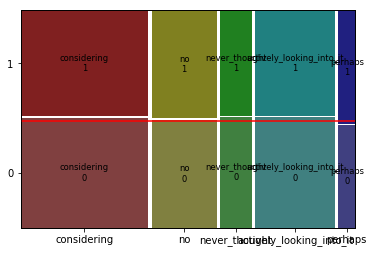

In [56]:
mosaic(mobile, ['CONSIDERING_CHANGE_OF_PLAN', 'CHURN'], gap = 0.01)
plt.axhline(mobile['CHURN'].mean(), color  = 'r')
plt.show()

In [57]:
COPCK = pd.crosstab(mobile['CONSIDERING_CHANGE_OF_PLAN'], mobile['CHURN'])
result = spst.chi2_contingency(COPCK)
print('카이검정 : ', result[0])
print('p_value : ',result[1])
print('자유도 : ', result[2])

카이검정 :  5.421434419620688
p_value :  0.24672225866799702
자유도 :  4


1. 변경계획설문에 따른 이탈여부는 관계가 없다.
2. 설문에 대한 타당성 여부

### (2) 숫자형 Feature --> CHURN

* 숫자형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  
    ① 그래프 : histogram, densityplot   
    ② 수치화 : 로지스틱회귀

#### 1) INCOME --> CHURN


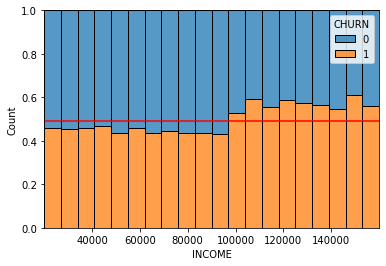

In [60]:
sns.histplot(x= 'INCOME', hue = 'CHURN', data = mobile, multiple = 'fill', bins = 20)
plt.axhline(mobile['CHURN'].mean(),color = 'r')
plt.show()

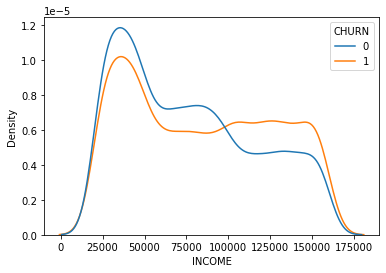

In [61]:
sns.kdeplot(x='INCOME', data = mobile, hue ='CHURN', common_norm = False)
plt.show()

In [65]:
model = sm.Logit(mobile['CHURN'], mobile['INCOME'])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.692683
         Iterations 2
INCOME    0.000044
dtype: float64


1.연 수입액이 10만 달러 이상일 경우 이탈율이 높아지는 것을 알수 있다.

2.이동통신사의 프리미어 서비스가 없어 연수입액이 높은 고객이 이탈할수 있음.

#### 2) OVERAGE --> CHURN


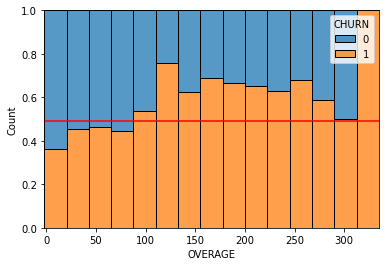

In [67]:
sns.histplot(x= 'OVERAGE', hue = 'CHURN', data = mobile, multiple = 'fill', bins = 15)
plt.axhline(mobile['CHURN'].mean(),color = 'r')
plt.show()

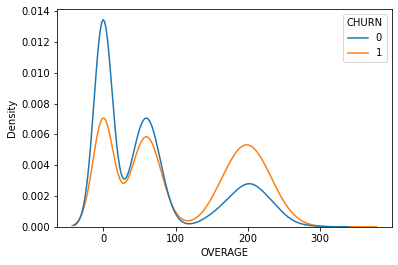

In [68]:
sns.kdeplot(x='OVERAGE', data = mobile, hue ='CHURN', common_norm = False)
plt.show()

In [69]:
model = sm.Logit(mobile['CHURN'], mobile['OVERAGE'])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.680553
         Iterations 4
OVERAGE    3.521095e-97
dtype: float64


1. 월 초과 사용시간이 많은 구간에서 높은 이탈율을 가지고 있다.
2. 통신사가 제공하는 요금제의 사용시간의 부족으로 인한 불만 있을수 있음.
3. 연 수입액 - 월 초과 사용시간 간의 데이터 분석 필요.

#### 3) LEFTOVER --> CHURN


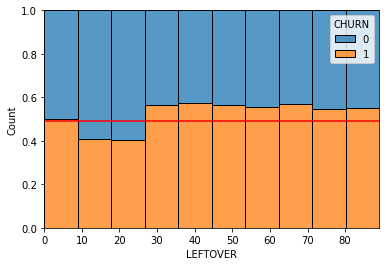

In [71]:
sns.histplot(x= 'LEFTOVER', hue = 'CHURN', data = mobile, multiple = 'fill', bins = 10)
plt.axhline(mobile['CHURN'].mean(),color = 'r')
plt.show()

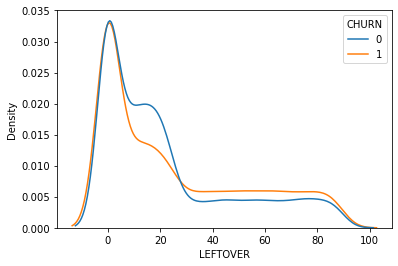

In [72]:
sns.kdeplot(x='LEFTOVER', data = mobile, hue ='CHURN', common_norm = False)
plt.show()

In [73]:
model = sm.Logit(mobile['CHURN'], mobile['LEFTOVER'])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.692532
         Iterations 3
LEFTOVER    0.000003
dtype: float64


1. 월 사용 잔여시간이 27%이상일 경우 이탈율이 높다.

2. 월 사용 잔여시간 - 월 초과사용시간 간의 데이터 분석 필요.

#### 4) HANDSET_PRICE --> CHURN


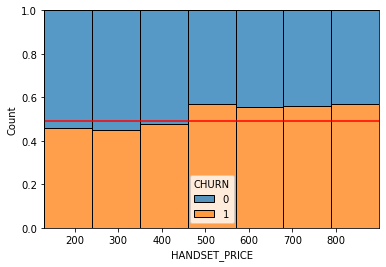

In [77]:
sns.histplot(x= 'HANDSET_PRICE', hue = 'CHURN', data = mobile, multiple = 'fill', bins = 7)
plt.axhline(mobile['CHURN'].mean(),color = 'r')
plt.show()

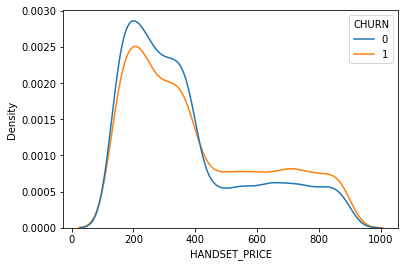

In [78]:
sns.kdeplot(x='HANDSET_PRICE', data = mobile, hue ='CHURN', common_norm = False)
plt.show()

In [79]:
model = sm.Logit(mobile['CHURN'], mobile['HANDSET_PRICE'])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.692730
         Iterations 3
HANDSET_PRICE    0.000107
dtype: float64


1. 핸드폰의 가격이 450달러 이상인 경우 이탈율이 증가한다.

2. 프리미엄 핸드폰에 대한 서비스 부족.

3. 핸드폰의 가격 - 연수입액 데이터의 분석 필요.

## 4.관계 정리

### 1) 강한관계의 변수

OVERAGE,INCOME,HADSET_PRICE

### 2) 약한관계의 변수

LEFTOVER

### 3) 관계 없음

REPORTED_SATISFACTION, CONSIDERING_CHANGE_OF_PLAN, COLLEGE

## 5.추가 분석

만족도 설문과 변경계획 설문에 대한 이탈여부와는 전혀 관계가 없다. 설문에 대한 타당성을 확인 해볼 필요.

연수입액, 월 사용잔여시간, 핸드폰 가격이 비슷한 형태의 그래프를 가진다. 이에 대한 분석 필요.

1) INCOME - HANDSET_PRICE

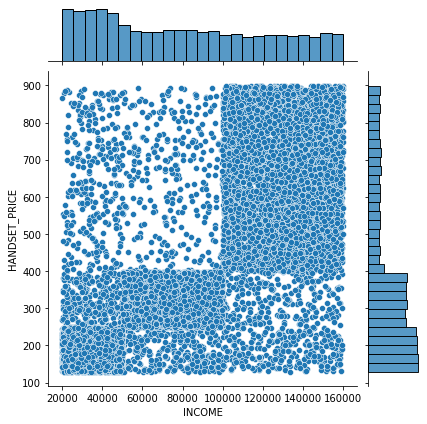

In [109]:
sns.jointplot(x='INCOME', y='HANDSET_PRICE', data = mobile)
plt.show()

연 수입액이 높을수록 높은 가격대의 핸드폰 사용.

2) CONSIDERING_CHANGE_OF_PLAN - REPORTED_SATISFACTION

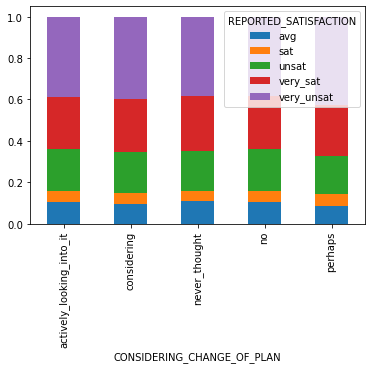

In [119]:
RC = pd.crosstab(mobile['CONSIDERING_CHANGE_OF_PLAN'], mobile['REPORTED_SATISFACTION'], normalize = 'index')
RC.plot.bar(stacked = True)
plt.show()

변경계획설문에 대한 만족도의 설문 결과의 비율이 같다. 설문 조사의 타당성이 없다.

# 분석 결론

높은 가격대의 휴대폰을 사용하고 높은 연수입액을 가진 고객들의 이탈율이 높다. 이러한 고객들을 위한 프리미엄 서비스 필요.

설문에 대한 타당성이 없다. 설문조사에 대한 문제점 파악 필요